In [2]:
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

import pandas as pd
import tqdm
import h5py
from Bio import SeqIO

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2

In [3]:
def plot_save(history, filename):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['auc_roc'], label='Train AUC')
    plt.plot(history.history['val_auc_roc'], label='Val AUC')
    plt.legend()
    plt.savefig(filename)
    plt.show()
    
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['auc_roc'], label='Train AUC')
    plt.plot(history.history['val_auc_roc'], label='Val AUC')
    plt.legend()
    plt.show()

In [4]:
def prot_t5_model():
    # prot_t5
    M1_input = Input(shape=(1024,))
    M1_dense_1 = Dense(256)(M1_input)
    drop_out = Dropout(0.4)(M1_dense_1)
   
    M1_dense_2 = Dense(64, activation='relu')(drop_out)
    drop_out = Dropout(0.4)(M1_dense_2)
    M1_dense_3 = Dense(1, activation = 'sigmoid')(drop_out)
    model = Model(inputs=M1_input, outputs=M1_dense_3)
    return model

In [5]:
def read_h5(path):
    hf = h5py.File(path, 'r')
    mat = np.array(hf["embedding"])
    hf.close()
    return mat

In [6]:
test_positive_ST_embedding_pos = read_h5("../embeddings/test_positive_ST_embedding.h5")
test_negative_ST_embedding_pos = read_h5("../embeddings/test_negative_ST_embedding.h5")

In [7]:
test_positive_ST_labels = np.ones(test_positive_ST_embedding_pos.shape[0])
test_negative_ST_labels = np.zeros(test_negative_ST_embedding_pos.shape[0])

test_ST_labels = np.concatenate((test_positive_ST_labels, test_negative_ST_labels), axis = 0)
X_test_full_ST_embedding = np.vstack((test_positive_ST_embedding_pos, test_negative_ST_embedding_pos))

In [8]:
train_positive_ST_embedding_pos = read_h5("../embeddings/train_positive_ST_embedding.h5")
train_negative_ST_embedding_pos = read_h5("../embeddings/train_negative_ST_embedding.h5")

In [9]:
train_positive_ST_labels = np.ones(train_positive_ST_embedding_pos.shape[0])
train_negative_ST_labels = np.zeros(train_negative_ST_embedding_pos.shape[0])

train_ST_labels = np.concatenate((train_positive_ST_labels, train_negative_ST_labels), axis = 0)
X_train_full_ST_embedding = np.vstack((train_positive_ST_embedding_pos, train_negative_ST_embedding_pos))

In [10]:
X_train_full_ST_embedding.shape, train_ST_labels.shape,  X_test_full_ST_embedding.shape, test_ST_labels.shape

((1779, 1024), (1779,), (446, 1024), (446,))

In [11]:
def get_input_for_embedding(fasta_file):
    # This is returning just integers to feed to embedding layer
    
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    #print(char_to_int)
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        try:
            integer_encoded = [char_to_int[char] for char in data]
        except:
            continue
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    print(encodings.shape)
    return encodings


# convert sequences to integer encoding, for embedding
test_positive_ST_CNN = get_input_for_embedding('../dataset/test_Pos_ST.fasta')
test_negative_ST_CNN = get_input_for_embedding('../dataset/test_Neg_ST.fasta')

train_positive_ST_CNN = get_input_for_embedding('../dataset/train_Pos_ST.fasta')
train_negative_ST_CNN = get_input_for_embedding('../dataset/train_Neg_ST.fasta')

(222, 33)
(224, 33)
(890, 33)
(889, 33)


In [12]:
X_train_CNN = np.vstack((train_positive_ST_CNN, train_negative_ST_CNN))
X_test_CNN = np.vstack((test_positive_ST_CNN, test_negative_ST_CNN))
X_train_CNN.shape, X_test_CNN.shape, train_ST_labels.shape, test_ST_labels.shape

((1779, 33), (446, 33), (1779,), (446,))

In [13]:
X_train_CNN, train_ST_labels

(array([[ 2, 18, 16, ..., 15, 14, 15],
        [15,  7, 12, ...,  1, 16,  5],
        [ 5, 14,  5, ..., 15, 16, 18],
        ...,
        [ 0, 14, 10, ..., 19, 15,  7],
        [ 8,  0, 15, ...,  1, 10, 10],
        [ 3,  0, 10, ...,  3, 18, 11]]),
 array([1., 1., 1., ..., 0., 0., 0.]))

In [14]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Layer, GlobalAveragePooling1D, Input, GlobalAveragePooling2D


def CNN_model():
    model = Sequential()
    model.add(Embedding(256, 21, input_length=33))
    model.add(Lambda(lambda x: tf.expand_dims(x, 3)))
    model.add(Conv2D(32, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model



class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(2 * ff_dim, activation="relu"), Dense(embed_dim)] #Dense(4 * ff_dim, activation="relu")
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs, training):
        attn_output, attention_scores = self.att(inputs, inputs, inputs, return_attention_scores=True, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), attention_scores


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [15]:
# Pretraining with Phosphorylation dataset

# S
pre_test_positive_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_S.fasta')
pre_test_negative_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_S.fasta')

pre_train_positive_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_S.fasta')
pre_train_negative_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_neg_S.fasta')

# T
pre_test_positive_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_T.fasta')
pre_test_negative_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_T.fasta')

pre_train_positive_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_T.fasta')
pre_train_negative_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_neg_T.fasta')


pre_test_pos_ST_CNN = np.vstack((pre_test_positive_S_CNN, pre_test_positive_T_CNN))
pre_test_neg_ST_CNN = np.vstack((pre_test_negative_S_CNN, pre_test_negative_T_CNN))

pre_train_pos_ST_CNN = np.vstack((pre_train_positive_S_CNN, pre_train_positive_T_CNN))
pre_train_neg_ST_CNN = np.vstack((pre_train_negative_S_CNN, pre_train_negative_T_CNN))

(3366, 33)
(3367, 33)
(13466, 33)
(13464, 33)
(856, 33)
(858, 33)
(3420, 33)
(3419, 33)


In [16]:
pre_test_pos_ST_CNN.shape, pre_test_neg_ST_CNN.shape, pre_train_pos_ST_CNN.shape, pre_train_neg_ST_CNN.shape

((4222, 33), (4225, 33), (16886, 33), (16883, 33))

In [17]:
pre_test_ST = np.vstack((pre_test_pos_ST_CNN, pre_test_neg_ST_CNN))

pre_test_positive_ST_labels = np.ones(pre_test_pos_ST_CNN.shape[0])
pre_test_negative_ST_labels = np.zeros(pre_test_neg_ST_CNN.shape[0])

pre_test_ST_labels = np.concatenate((pre_test_positive_ST_labels, pre_test_negative_ST_labels), axis = 0)
pre_test_ST.shape, pre_test_ST_labels.shape

((8447, 33), (8447,))

In [18]:
pre_train_ST = np.vstack((pre_train_pos_ST_CNN, pre_train_neg_ST_CNN))

pre_train_positive_ST_labels = np.ones(pre_train_pos_ST_CNN.shape[0])
pre_train_negative_ST_labels = np.zeros(pre_train_neg_ST_CNN.shape[0])

pre_train_ST_labels = np.concatenate((pre_train_positive_ST_labels, pre_train_negative_ST_labels), axis = 0)
pre_train_ST.shape, pre_train_ST_labels.shape

((33769, 33), (33769,))

In [19]:
pre_train_ST, pre_train_ST_labels

(array([[ 5,  3,  7, ...,  3,  9,  5],
        [14,  0, 14, ..., 14,  2,  5],
        [ 5, 10,  0, ..., 16, 13, 14],
        ...,
        [11, 18,  0, ..., 10, 10, 14],
        [18, 18, 18, ...,  6,  6,  6],
        [ 2,  0,  6, ..., 13, 19, 16]]),
 array([1., 1., 1., ..., 0., 0., 0.]))

In [20]:
X_train_CNN, train_ST_labels

(array([[ 2, 18, 16, ..., 15, 14, 15],
        [15,  7, 12, ...,  1, 16,  5],
        [ 5, 14,  5, ..., 15, 16, 18],
        ...,
        [ 0, 14, 10, ..., 19, 15,  7],
        [ 8,  0, 15, ...,  1, 10, 10],
        [ 3,  0, 10, ...,  3, 18, 11]]),
 array([1., 1., 1., ..., 0., 0., 0.]))

2023-05-15 10:14:29.882714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-15 10:14:29.882753: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-15 10:14:29.882784: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anupkumar-HP-ProBook-450-G5): /proc/driver/nvidia/version does not exist
2023-05-15 10:14:29.883461: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


PRE Training CNN model...
Epoch 1/20
  3/132 [..............................] - ETA: 8s - loss: 0.6994 - accuracy: 0.4661 - auc_roc: 0.4677

2023-05-15 10:14:30.841121: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18252084 exceeds 10% of free system memory.
2023-05-15 10:14:30.841194: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18252084 exceeds 10% of free system memory.
2023-05-15 10:14:30.910854: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18252084 exceeds 10% of free system memory.
2023-05-15 10:14:30.910946: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18252084 exceeds 10% of free system memory.
2023-05-15 10:14:30.981006: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18252084 exceeds 10% of free system memory.


132/132 [==============================] - 11s 77ms/step - loss: 0.6099 - accuracy: 0.6696 - auc_roc: 0.7304 - val_loss: 0.5576 - val_accuracy: 0.7366 - val_auc_roc: 0.8077
Epoch 2/20
132/132 [==============================] - 14s 109ms/step - loss: 0.5639 - accuracy: 0.7215 - auc_roc: 0.7830 - val_loss: 0.5424 - val_accuracy: 0.7410 - val_auc_roc: 0.8154
Epoch 3/20
132/132 [==============================] - 12s 94ms/step - loss: 0.5546 - accuracy: 0.7277 - auc_roc: 0.7921 - val_loss: 0.5397 - val_accuracy: 0.7444 - val_auc_roc: 0.8204
Epoch 4/20
132/132 [==============================] - 13s 95ms/step - loss: 0.5483 - accuracy: 0.7311 - auc_roc: 0.7982 - val_loss: 0.5297 - val_accuracy: 0.7503 - val_auc_roc: 0.8246
Epoch 5/20
132/132 [==============================] - 13s 99ms/step - loss: 0.5475 - accuracy: 0.7327 - auc_roc: 0.7996 - val_loss: 0.5220 - val_accuracy: 0.7523 - val_auc_roc: 0.8269
Epoch 6/20
132/132 [==============================] - 13s 101ms/step - loss: 0.5408 - accu

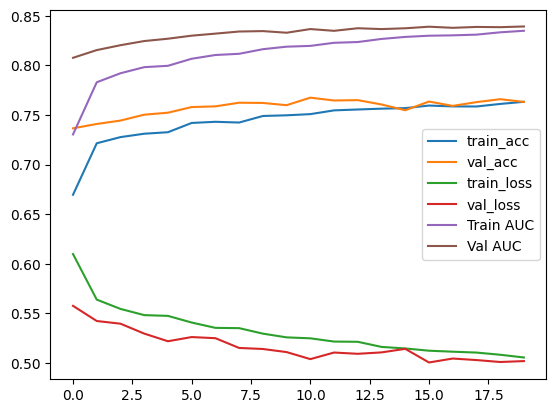


 Acc: 0.7632295489522908, MCC: 0.5313078347161472, SN:0.8304121269540502, SP:0.696094674556213, 
 CM:[[2941 1284]
 [ 716 3506]]


In [21]:
# Pretraining CNN

n_epo_cnn = 20

metrics = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]

model_A = CNN_model()
model_A.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

#model_A.summary()

print("PRE Training CNN model...")

checkpointer = ModelCheckpoint(filepath="../models/pre_model_A.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

pre_history_A = model_A.fit(pre_train_ST, pre_train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer],
    validation_data=(pre_test_ST, pre_test_ST_labels))

# Save model
#model_A.save_weights('../models/pre_model_A.h5')

y_pred = model_A.predict(pre_test_ST).reshape(pre_test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
a_pre_test_ST_labels = np.array(pre_test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(a_pre_test_ST_labels, y_pred)
mcc = matthews_corrcoef(a_pre_test_ST_labels, y_pred)
acc = accuracy_score(a_pre_test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(pre_history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [22]:
# transformer based embedding model
def transformer_model():
    vocab_size = 21
    embed_dim = 128 #config["embedding_dim"]
    ff_dim = 128 #config["feed_forward_dim"]
    max_len = 33 #config["maximum_path_length"]
    dropout = 0.4 #config["dropout"]
    n_heads = 2

    inputs = Input(shape=(max_len,))
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, n_heads, ff_dim)
    x, weights = transformer_block(x)
    x = GlobalAveragePooling1D()(x) #GlobalAveragePooling1D
    x = Dropout(dropout)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs=inputs, outputs=[outputs])

PRE Training Transformer model...
Epoch 1/20
132/132 [==============================] - 48s 349ms/step - loss: 0.6210 - accuracy: 0.6572 - auc_roc: 0.7398 - val_loss: 0.6221 - val_accuracy: 0.6349 - val_auc_roc: 0.7557
Epoch 2/20
132/132 [==============================] - 48s 363ms/step - loss: 0.5866 - accuracy: 0.6904 - auc_roc: 0.7526 - val_loss: 0.5359 - val_accuracy: 0.7335 - val_auc_roc: 0.8104
Epoch 3/20
132/132 [==============================] - 47s 360ms/step - loss: 0.5477 - accuracy: 0.7266 - auc_roc: 0.7978 - val_loss: 0.5229 - val_accuracy: 0.7432 - val_auc_roc: 0.8235
Epoch 4/20
132/132 [==============================] - 39s 298ms/step - loss: 0.5349 - accuracy: 0.7373 - auc_roc: 0.8089 - val_loss: 0.5175 - val_accuracy: 0.7483 - val_auc_roc: 0.8254
Epoch 5/20
132/132 [==============================] - 39s 300ms/step - loss: 0.5317 - accuracy: 0.7393 - auc_roc: 0.8118 - val_loss: 0.5195 - val_accuracy: 0.7412 - val_auc_roc: 0.8297
Epoch 6/20
132/132 [=====================

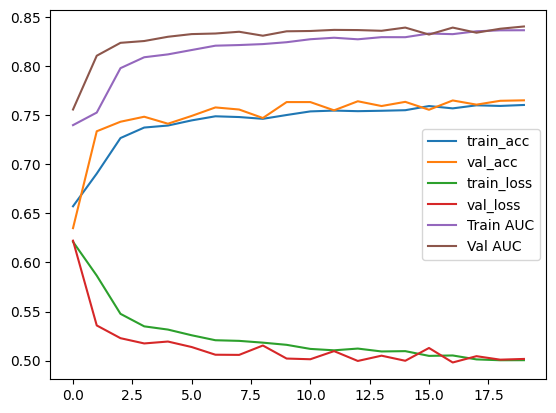


 Acc: 0.7650053273351486, MCC: 0.5362472189129632, SN:0.8408337280909521, SP:0.6892307692307692, 
 CM:[[2912 1313]
 [ 672 3550]]


In [23]:
# Pretraining transformer

n_epo_transformer = 20
model_C = transformer_model()
model_C.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

#model_C.summary()

checkpointer = ModelCheckpoint(filepath="../models/pre_model_C.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

print("PRE Training Transformer model...")

pre_history_C = model_C.fit(pre_train_ST, pre_train_ST_labels, batch_size=256, epochs=n_epo_transformer, verbose=1, callbacks=[checkpointer],
    validation_data=(pre_test_ST, pre_test_ST_labels))

# Save model
#model_C.save_weights('../models/pre_model_C.h5')

y_pred = model_C.predict(pre_test_ST).reshape(pre_test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
a_pre_test_ST_labels = np.array(pre_test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(a_pre_test_ST_labels, y_pred)
mcc = matthews_corrcoef(a_pre_test_ST_labels, y_pred)
acc = accuracy_score(a_pre_test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(pre_history_C)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [24]:
## Predict on real data using CNN

y_pred = model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

## Predict on real data using transformers

y_pred = model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


 Acc: 0.8071748878923767, MCC: 0.6269872293519306, SN:0.9054054054054054, SP:0.7098214285714286, 
 CM:[[159  65]
 [ 21 201]]

 Acc: 0.7937219730941704, MCC: 0.5984765018286745, SN:0.8873873873873874, SP:0.7008928571428571, 
 CM:[[157  67]
 [ 25 197]]


Training CNN model...
Epoch 1/50
7/7 [==============================] - 2s 146ms/step - loss: 0.5438 - accuracy: 0.7364 - auc_roc: 0.8335 - val_loss: 0.4884 - val_accuracy: 0.7735 - val_auc_roc: 0.8689
Epoch 2/50
7/7 [==============================] - 1s 85ms/step - loss: 0.5220 - accuracy: 0.7572 - auc_roc: 0.8193 - val_loss: 0.4826 - val_accuracy: 0.7758 - val_auc_roc: 0.8727
Epoch 3/50
7/7 [==============================] - 1s 99ms/step - loss: 0.5154 - accuracy: 0.7650 - auc_roc: 0.8267 - val_loss: 0.4692 - val_accuracy: 0.7825 - val_auc_roc: 0.8750
Epoch 4/50
7/7 [==============================] - 1s 103ms/step - loss: 0.5133 - accuracy: 0.7617 - auc_roc: 0.8283 - val_loss: 0.4767 - val_accuracy: 0.7870 - val_auc_roc: 0.8799
Epoch 5/50
7/7 [==============================] - 1s 91ms/step - loss: 0.5007 - accuracy: 0.7678 - auc_roc: 0.8376 - val_loss: 0.4701 - val_accuracy: 0.7735 - val_auc_roc: 0.8781
Epoch 6/50
7/7 [==============================] - 1s 96ms/step - loss: 0.4972 - a

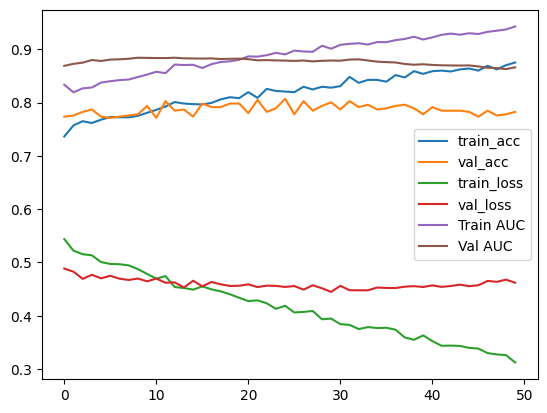


 Acc: 0.7825112107623319, MCC: 0.567240964028941, SN:0.8243243243243243, SP:0.7410714285714286, 
 CM:[[166  58]
 [ 39 183]]



In [25]:
# Training DE-Phosphorylation

iteration = 1
n_epo_cnn = 50

model_A = CNN_model()
model_A.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)
model_A.load_weights('../models/pre_model_A.h5')
#model_A.summary()

print("Training CNN model...")

#metrics = ['accuracy', tf.keras.metrics.AUC()]

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_A.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_A = model_A.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer], 
                        validation_data=(X_test_CNN, test_ST_labels))

# Save model
#model_A.save_weights('../models/re_train_model_A.h5')

y_pred = model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

In [26]:
loaded_model_A = CNN_model()
loaded_model_A.load_weights("../models/re_train_model_A.h5")
y_pred = loaded_model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


 Acc: 0.8071748878923767, MCC: 0.6150380353888494, SN:0.8288288288288288, SP:0.7857142857142857, 
 CM:[[176  48]
 [ 38 184]]


Training Embedding model...
Epoch 1/10
7/7 [==============================] - 1s 57ms/step - loss: 0.6211 - accuracy: 0.6571 - auc_roc: 0.7570 - val_loss: 0.5021 - val_accuracy: 0.7735 - val_auc_roc: 0.8343
Epoch 2/10
7/7 [==============================] - 0s 12ms/step - loss: 0.5366 - accuracy: 0.7426 - auc_roc: 0.8106 - val_loss: 0.4867 - val_accuracy: 0.7825 - val_auc_roc: 0.8482
Epoch 3/10
7/7 [==============================] - 0s 13ms/step - loss: 0.5057 - accuracy: 0.7617 - auc_roc: 0.8355 - val_loss: 0.4787 - val_accuracy: 0.7982 - val_auc_roc: 0.8596
Epoch 4/10
7/7 [==============================] - 0s 13ms/step - loss: 0.4826 - accuracy: 0.7841 - auc_roc: 0.8535 - val_loss: 0.4622 - val_accuracy: 0.8049 - val_auc_roc: 0.8644
Epoch 5/10
7/7 [==============================] - 0s 11ms/step - loss: 0.4655 - accuracy: 0.7768 - auc_roc: 0.8608 - val_loss: 0.4572 - val_accuracy: 0.8049 - val_auc_roc: 0.8665
Epoch 6/10
7/7 [==============================] - 0s 14ms/step - loss: 0.4417

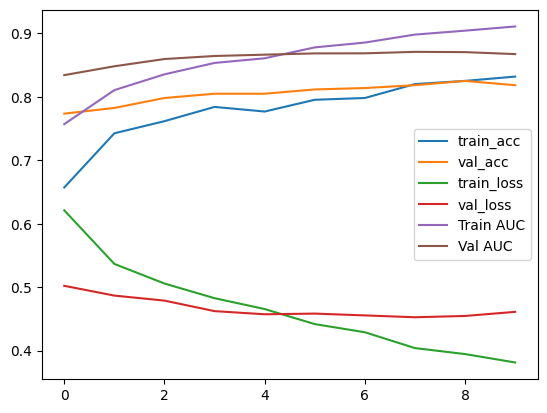


 Acc: 0.8183856502242153, MCC: 0.6370268803537882, SN:0.8018018018018018, SP:0.8348214285714286, 
 CM:[[187  37]
 [ 44 178]]


 Acc: 0.8251121076233184, MCC: 0.6502936869774758, SN:0.8153153153153153, SP:0.8348214285714286, 
 CM:[[187  37]
 [ 41 181]]


In [27]:
########### Model B

print("Training Embedding model...")

n_epo_embed = 10
model_B = prot_t5_model()
model_B.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='auto')

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_B.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_B = model_B.fit(X_train_full_ST_embedding, train_ST_labels, batch_size=256, epochs=n_epo_embed, verbose=1, 
                        callbacks=[checkpointer], validation_data=(X_test_full_ST_embedding, test_ST_labels))

#model_B.save_weights('../models/re_train_model_B.h5')

y_pred = model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(history_B)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

loaded_model_B = prot_t5_model()
loaded_model_B.load_weights("../models/re_train_model_B.h5")
y_pred = loaded_model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 33)]              0         
                                                                 
 token_and_position_embeddin  (None, 33, 128)          6912      
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_1 (Transf  ((None, 33, 128),        214912    
 ormerBlock)                  (None, 2, 33, 33))                 
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_16 (Dropout)        (None, 128)               0   

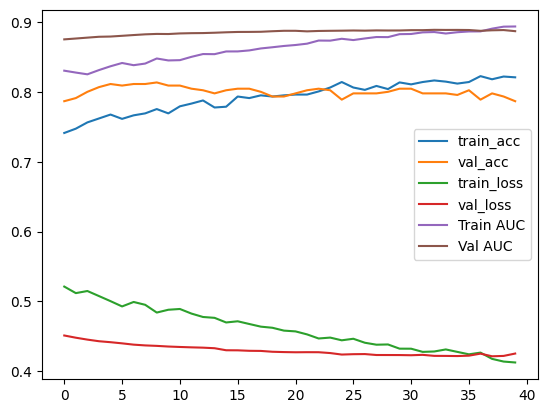


 Acc: 0.7869955156950673, MCC: 0.5758025495302833, SN:0.8243243243243243, SP:0.75, 
 CM:[[168  56]
 [ 39 183]]


 Acc: 0.8139013452914798, MCC: 0.628961613817598, SN:0.8423423423423423, SP:0.7857142857142857, 
 CM:[[176  48]
 [ 35 187]]


In [28]:
############# Training Transformer


model_C = transformer_model()
model_C.load_weights('../models/pre_model_C.h5')
model_C.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=metrics)

model_C.summary()

n_epo_transformer = 40

print("Training Transformer model...")

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_C.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

history_C = model_C.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_transformer, verbose=1
                        ,callbacks=[checkpointer]
                        , validation_data=(X_test_CNN, test_ST_labels))

# Save model
#model_C.save_weights('../models/re_train_model_C.h5')

y_pred = model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_C)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

loaded_model_C = transformer_model()
loaded_model_C.load_weights("../models/re_train_model_C.h5")
y_pred = loaded_model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [29]:
# load models from file
def load_A_models():
    model = CNN_model()
    model.load_weights('../models/re_train_model_A.h5')
    return model


def load_B_models():
    model = prot_t5_model()
    model.load_weights('../models/re_train_model_B.h5')
    return model


def load_C_models():
    model = transformer_model()
    model.load_weights('../models/re_train_model_C.h5')
    return model


# meta learner
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
    ensemble_inputs = [model.input for model in members]
    ensemble_outputs = [model.get_layer(index = len(model.layers) - 2).output for model in members]
    #print(ensemble_outputs)
    #for item in ensemble_outputs:
    #    print(item)
    # outputs=re_stacked_model.get_layer(index=26).output
    merge = concatenate(ensemble_outputs)
    hidden = Dropout(0.4, name = 'dp_2')(merge)
    hidden = Dense(256, activation='relu', name = 'ds_1')(hidden)
    hidden = Dropout(0.4, name = 'dp_1')(hidden)
    hidden = Dense(32, activation='relu', name = 'ds_2')(hidden)
    output = Dense(1, activation='sigmoid', name = 'ds_4')(hidden)
    model = Model(inputs=ensemble_inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
    return model


# load all models
members = list()
model_A = load_A_models()
model_B = load_B_models()
model_C = load_C_models()

members.append(model_A)
members.append(model_B)
members.append(model_C)

n_epo_stacked = 20


print('Loaded %d models' % len(members))
stacked_model = define_stacked_model(members)


checkpointer = ModelCheckpoint(filepath="../models/pre_re_train_composite_model.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)


st_history = stacked_model.fit([X_train_CNN, X_train_full_ST_embedding, X_train_CNN], train_ST_labels, 
                               epochs=n_epo_stacked, verbose=1, callbacks = [checkpointer],
                               validation_data=([X_test_CNN, X_test_full_ST_embedding, X_test_CNN], test_ST_labels))

# X_train_full_ST_embedding, X_test_full_ST_embedding


Loaded 3 models
Epoch 1/20
56/56 [==============================] - 4s 36ms/step - loss: 0.4713 - accuracy: 0.7926 - auc_roc: 0.8636 - val_loss: 0.4155 - val_accuracy: 0.8341 - val_auc_roc: 0.8993
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 0.3925 - accuracy: 0.8314 - auc_roc: 0.9023 - val_loss: 0.4318 - val_accuracy: 0.8318 - val_auc_roc: 0.8915
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 0.3863 - accuracy: 0.8364 - auc_roc: 0.9049 - val_loss: 0.4345 - val_accuracy: 0.8274 - val_auc_roc: 0.8850
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 0.3816 - accuracy: 0.8404 - auc_roc: 0.9076 - val_loss: 0.4265 - val_accuracy: 0.8274 - val_auc_roc: 0.8867
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 0.3760 - accuracy: 0.8336 - auc_roc: 0.9100 - val_loss: 0.4400 - val_accuracy: 0.8251 - val_auc_roc: 0.8852
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 0.3813

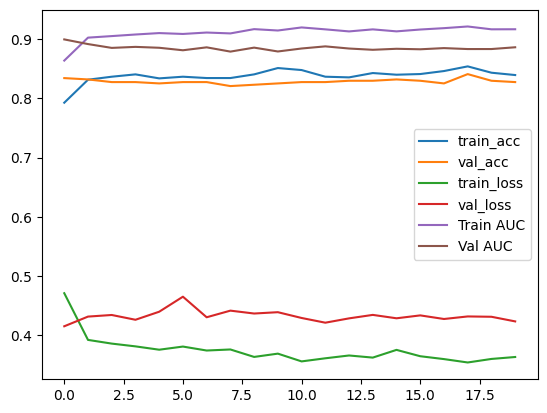


 Acc: 0.827354260089686, MCC: 0.6562912493976986, SN:0.8603603603603603, SP:0.7946428571428571, 
 CM:[[178  46]
 [ 31 191]]


 Acc: 0.8408071748878924, MCC: 0.6816888382536949, SN:0.8468468468468469, SP:0.8348214285714286, 
 CM:[[187  37]
 [ 34 188]]


In [30]:
y_pred = stacked_model.predict([X_test_CNN, X_test_full_ST_embedding, X_test_CNN]).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(st_history)

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

# Predict
re_stacked_model = define_stacked_model(members)
re_stacked_model.load_weights("../models/pre_re_train_composite_model.h5")
y_pred = re_stacked_model.predict([X_test_CNN, X_test_full_ST_embedding, X_test_CNN]).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [163]:
# load pretrained model
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.manifold import TSNE
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns
import h5py

#re_stacked_model.summary()

#print("Number of layers: ", len(re_stacked_model.layers))

# create truncated model
#truncated_ANN_model = Model(inputs=re_stacked_model.input,
#                                 outputs=re_stacked_model.get_layer(index=21).output) #20

loaded_model_B.summary()
print("Number of layers: ", len(loaded_model_B.layers))
truncated_CNN_model = Model(inputs=loaded_model_B.input,
                                 outputs=loaded_model_B.get_layer(index=len(loaded_model_B.layers) - 3).output) #20
hidden_features = truncated_CNN_model.predict([X_train_full_ST_embedding])

hidden_labels = train_ST_labels

print(hidden_features.shape)

df = pd.DataFrame()
df['Target'] = hidden_labels

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_14 (Dense)            (None, 256)               262400    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                16448     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 278,913
Trainable params: 278,913
Non-trainab

In [164]:
#hidden_features = X_test_full_ST_embedding #X_train_full_ST_embedding

# X_train_full_ST_embedding, train_ST_labels, X_test_full_ST_embedding, test_ST_labels
                        

#print(hidden_features.shape)

#df = pd.DataFrame()
#df['Target'] = test_ST_labels #train_ST_labels

/home/anupkumar/anaconda3/envs/succsite/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


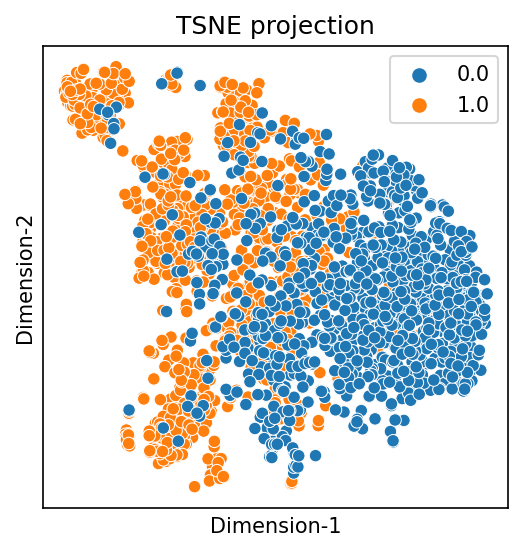

In [165]:
m = TSNE(learning_rate = "auto", perplexity = 100, random_state = 20)
tsne_features = m.fit_transform(hidden_features)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

sns.scatterplot(x="Dimension-1", y="Dimension-2", hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

plt.title("TSNE projection")
plt.legend().set_visible(True)
filename = "TSNE_Embedding_Pos_Neg.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

/home/anupkumar/anaconda3/envs/succsite/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


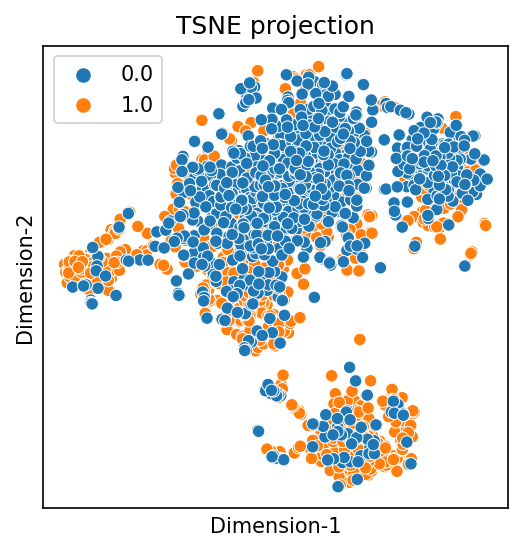

In [169]:
hidden_features_raw = X_train_full_ST_embedding

m_raw = TSNE(learning_rate = "auto", perplexity = 100, random_state = 20)

tsne_features = m_raw.fit_transform(hidden_features_raw)

df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

sns.scatterplot(x="Dimension-1", y="Dimension-2", hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

plt.title("TSNE projection")
plt.legend().set_visible(True)
filename = "TSNE_Embedding_Pos_Neg_Raw.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

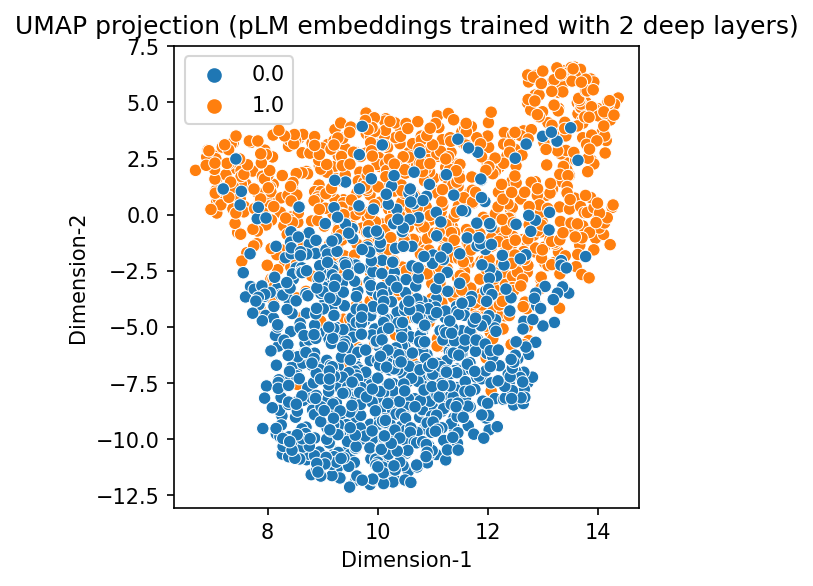

In [188]:
from umap import UMAP
from matplotlib.pyplot import figure

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

n_colors = 10

n_neighbors = 1000

min_dist = 0.99

n_components = 2

metric = "hsl_dist" #'euclidean'

umap_2d = UMAP(n_components=n_components, n_neighbors = n_neighbors, min_dist = min_dist, init = 'random', random_state = 0)

proj_2d = umap_2d.fit_transform(hidden_features)

df_umap = pd.DataFrame()

df_umap["Dimension-1"] = proj_2d[:,0]
df_umap["Dimension-2"] = proj_2d[:,1]

sns_plot = sns.scatterplot(x="Dimension-1", y="Dimension-2", hue=hidden_labels, data=df_umap).set(title="UMAP projection (pLM embeddings trained with 2 deep layers)")
filename = "UMAP_Embedding_Pos_Neg.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')

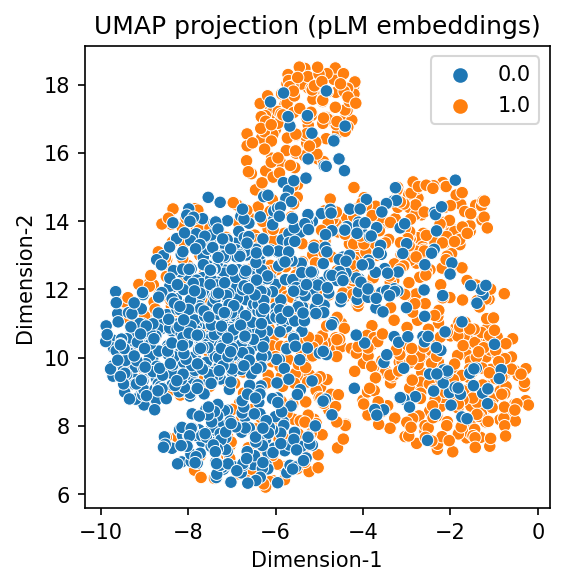

In [189]:

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

n_colors = 10

#n_neighbors = 1000

#min_dist = 0.99

#n_components=2

#metric='euclidean'

umap_2d_raw = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, init='random', random_state=0)

proj_2d = umap_2d_raw.fit_transform(hidden_features_raw)

df_umap = pd.DataFrame()

df_umap["Dimension-1"] = proj_2d[:,0]
df_umap["Dimension-2"] = proj_2d[:,1]

sns_plot = sns.scatterplot(x="Dimension-1", y="Dimension-2", hue=hidden_labels, data=df_umap).set(title="UMAP projection (pLM embeddings)")
filename = "UMAP_Embedding_Pos_Neg_pLM_embeddings.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')

In [190]:
np.random.seed(42)
data = np.random.rand(train_ST_labels.shape[0], 1024)

hidden_features_random = data # truncated_CNN_model.predict([X_train_full_ST_embedding])

hidden_labels = train_ST_labels

print(hidden_features.shape)

df = pd.DataFrame()
df['Target'] = hidden_labels

(1779, 64)


/home/anupkumar/anaconda3/envs/succsite/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


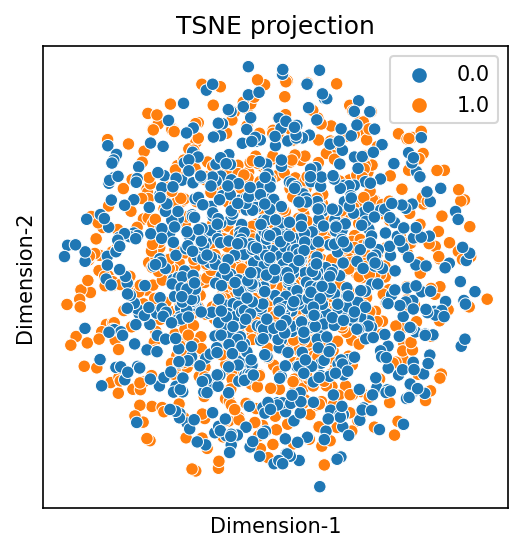

In [191]:
m_random = TSNE(learning_rate = "auto", perplexity = 100, random_state = 20)

tsne_features = m_random.fit_transform(hidden_features_random)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

sns.scatterplot(x="Dimension-1", y="Dimension-2", hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

plt.title("TSNE projection")
plt.legend().set_visible(True)
filename = "TSNE_Embedding_Pos_Neg_Random.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

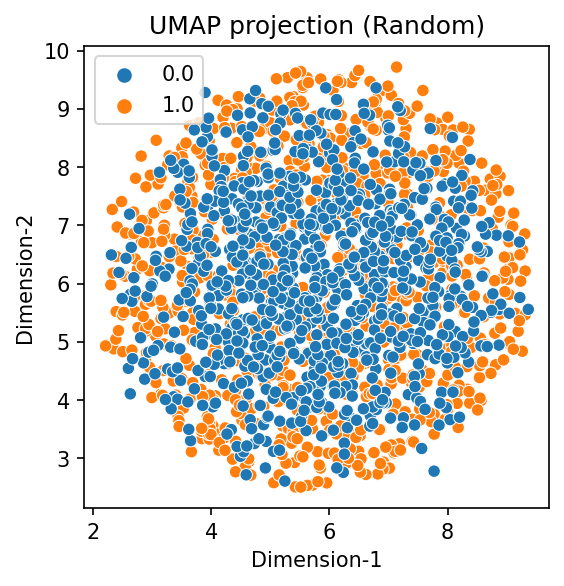

In [192]:
figsize = (4, 4)
figure(figsize=figsize, dpi=150)

n_colors = 10

#n_neighbors = 1000

#min_dist = 0.99

#n_components=2

#metric='euclidean'

umap_2d_random = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, init='random', random_state=0)

proj_2d = umap_2d_random.fit_transform(hidden_features_random)

df_umap = pd.DataFrame()

df_umap["Dimension-1"] = proj_2d[:,0]
df_umap["Dimension-2"] = proj_2d[:,1]

sns_plot = sns.scatterplot(x="Dimension-1", y="Dimension-2", hue=hidden_labels, data=df_umap).set(title="UMAP projection (Random)")
filename = "UMAP_Embedding_Pos_Neg_Random.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')

Epoch 1/10
7/7 [==============================] - 1s 40ms/step - loss: 0.9978 - accuracy: 0.4952 - auc_roc: 0.5912 - val_loss: 0.7453 - val_accuracy: 0.5000 - val_auc_roc: 0.3872
Epoch 2/10
7/7 [==============================] - 0s 11ms/step - loss: 0.7674 - accuracy: 0.5171 - auc_roc: 0.5204 - val_loss: 0.7445 - val_accuracy: 0.5000 - val_auc_roc: 0.3838
Epoch 3/10
7/7 [==============================] - 0s 10ms/step - loss: 0.7233 - accuracy: 0.5143 - auc_roc: 0.5150 - val_loss: 0.7466 - val_accuracy: 0.4978 - val_auc_roc: 0.3745
Epoch 4/10
7/7 [==============================] - 0s 13ms/step - loss: 0.7238 - accuracy: 0.4795 - auc_roc: 0.4819 - val_loss: 0.7479 - val_accuracy: 0.4978 - val_auc_roc: 0.3664
Epoch 5/10
7/7 [==============================] - 0s 12ms/step - loss: 0.7049 - accuracy: 0.4997 - auc_roc: 0.4948 - val_loss: 0.7519 - val_accuracy: 0.4978 - val_auc_roc: 0.3586
Epoch 6/10
7/7 [==============================] - 0s 12ms/step - loss: 0.7002 - accuracy: 0.4829 - auc_ro

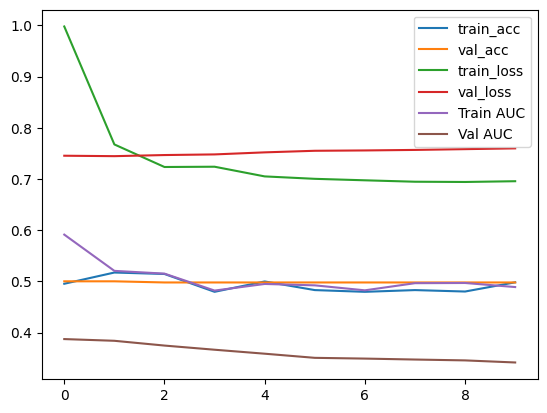


 Acc: 0.4977578475336323, MCC: -0.0668153104781061, SN:0.0, SP:0.9910714285714286, 
 CM:[[222   2]
 [222   0]]


 Acc: 0.8251121076233184, MCC: 0.6502936869774758, SN:0.8153153153153153, SP:0.8348214285714286, 
 CM:[[187  37]
 [ 41 181]]


In [195]:
np.random.seed(42)
random_data = np.random.rand(train_ST_labels.shape[0], 1024)

n_epo_embed = 10
random_re_train_model_B = prot_t5_model()
random_re_train_model_B.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='auto')

checkpointer = ModelCheckpoint(filepath="../models/random_re_train_model_B.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_B = random_re_train_model_B.fit(random_data, train_ST_labels, batch_size=256, epochs=n_epo_embed, verbose=1, 
                        callbacks=[checkpointer], validation_data=(X_test_full_ST_embedding, test_ST_labels))


y_pred = random_re_train_model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(history_B)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

loaded_model_B_random = prot_t5_model()
loaded_model_B_random.load_weights("../models/random_re_train_model_B.h5")
y_pred = loaded_model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [196]:
loaded_model_B_random.summary()
print("Number of layers: ", len(loaded_model_B_random.layers))
truncated_CNN_model = Model(inputs=loaded_model_B_random.input,
                                 outputs=loaded_model_B_random.get_layer(index=len(loaded_model_B_random.layers) - 3).output) #20
hidden_features_random_predicted = truncated_CNN_model.predict([random_data])

hidden_labels = train_ST_labels

print(hidden_features_random_predicted.shape)

df = pd.DataFrame()
df['Target'] = hidden_labels

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_46 (Dense)            (None, 256)               262400    
                                                                 
 dropout_36 (Dropout)        (None, 256)               0         
                                                                 
 dense_47 (Dense)            (None, 64)                16448     
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_48 (Dense)            (None, 1)                 65        
                                                                 
Total params: 278,913
Trainable params: 278,913
Non-traina

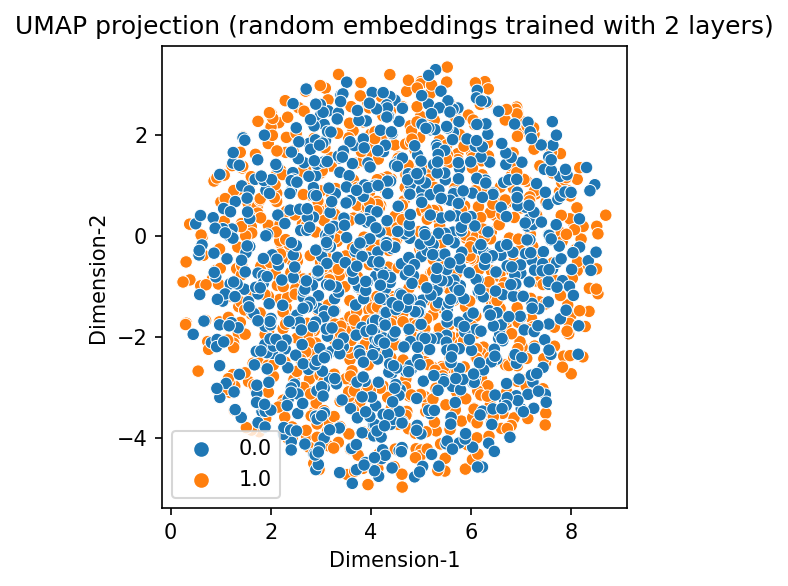

In [198]:
figsize = (4, 4)
figure(figsize=figsize, dpi=150)

n_colors = 10

#n_neighbors = 1000

#min_dist = 0.99

#n_components=2

#metric='euclidean'

umap_2d_raw = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, init='random', random_state=0)

proj_2d = umap_2d_raw.fit_transform(hidden_features_random_predicted)

df_umap = pd.DataFrame()

df_umap["Dimension-1"] = proj_2d[:,0]
df_umap["Dimension-2"] = proj_2d[:,1]

sns_plot = sns.scatterplot(x="Dimension-1", y="Dimension-2", hue=hidden_labels, data=df_umap).set(title="UMAP projection (random embeddings trained with 2 layers)")
filename = "UMAP_Embedding_Pos_Neg_pLM_random_trained.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')